<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [178]:
import warnings
import optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import List, Union, Tuple
from phik import phik_matrix

In [179]:
warnings.filterwarnings('ignore')
RANDOM_STATE = 0
TEST_SIZE = 0.1

## Анализ

In [180]:
def get_data(path: str, 
             idx_col: Union[int, List[int]], 
             parse_dates: Union[int, List[int]]
            ) -> pd.DataFrame:
    data = pd.read_csv(path, index_col=[idx_col], parse_dates=[parse_dates])
    data.sort_index(inplace=True)
    data = data.resample('1H').sum()
    return data

In [181]:
data = get_data('taxi.csv', 0, 0)

In [182]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


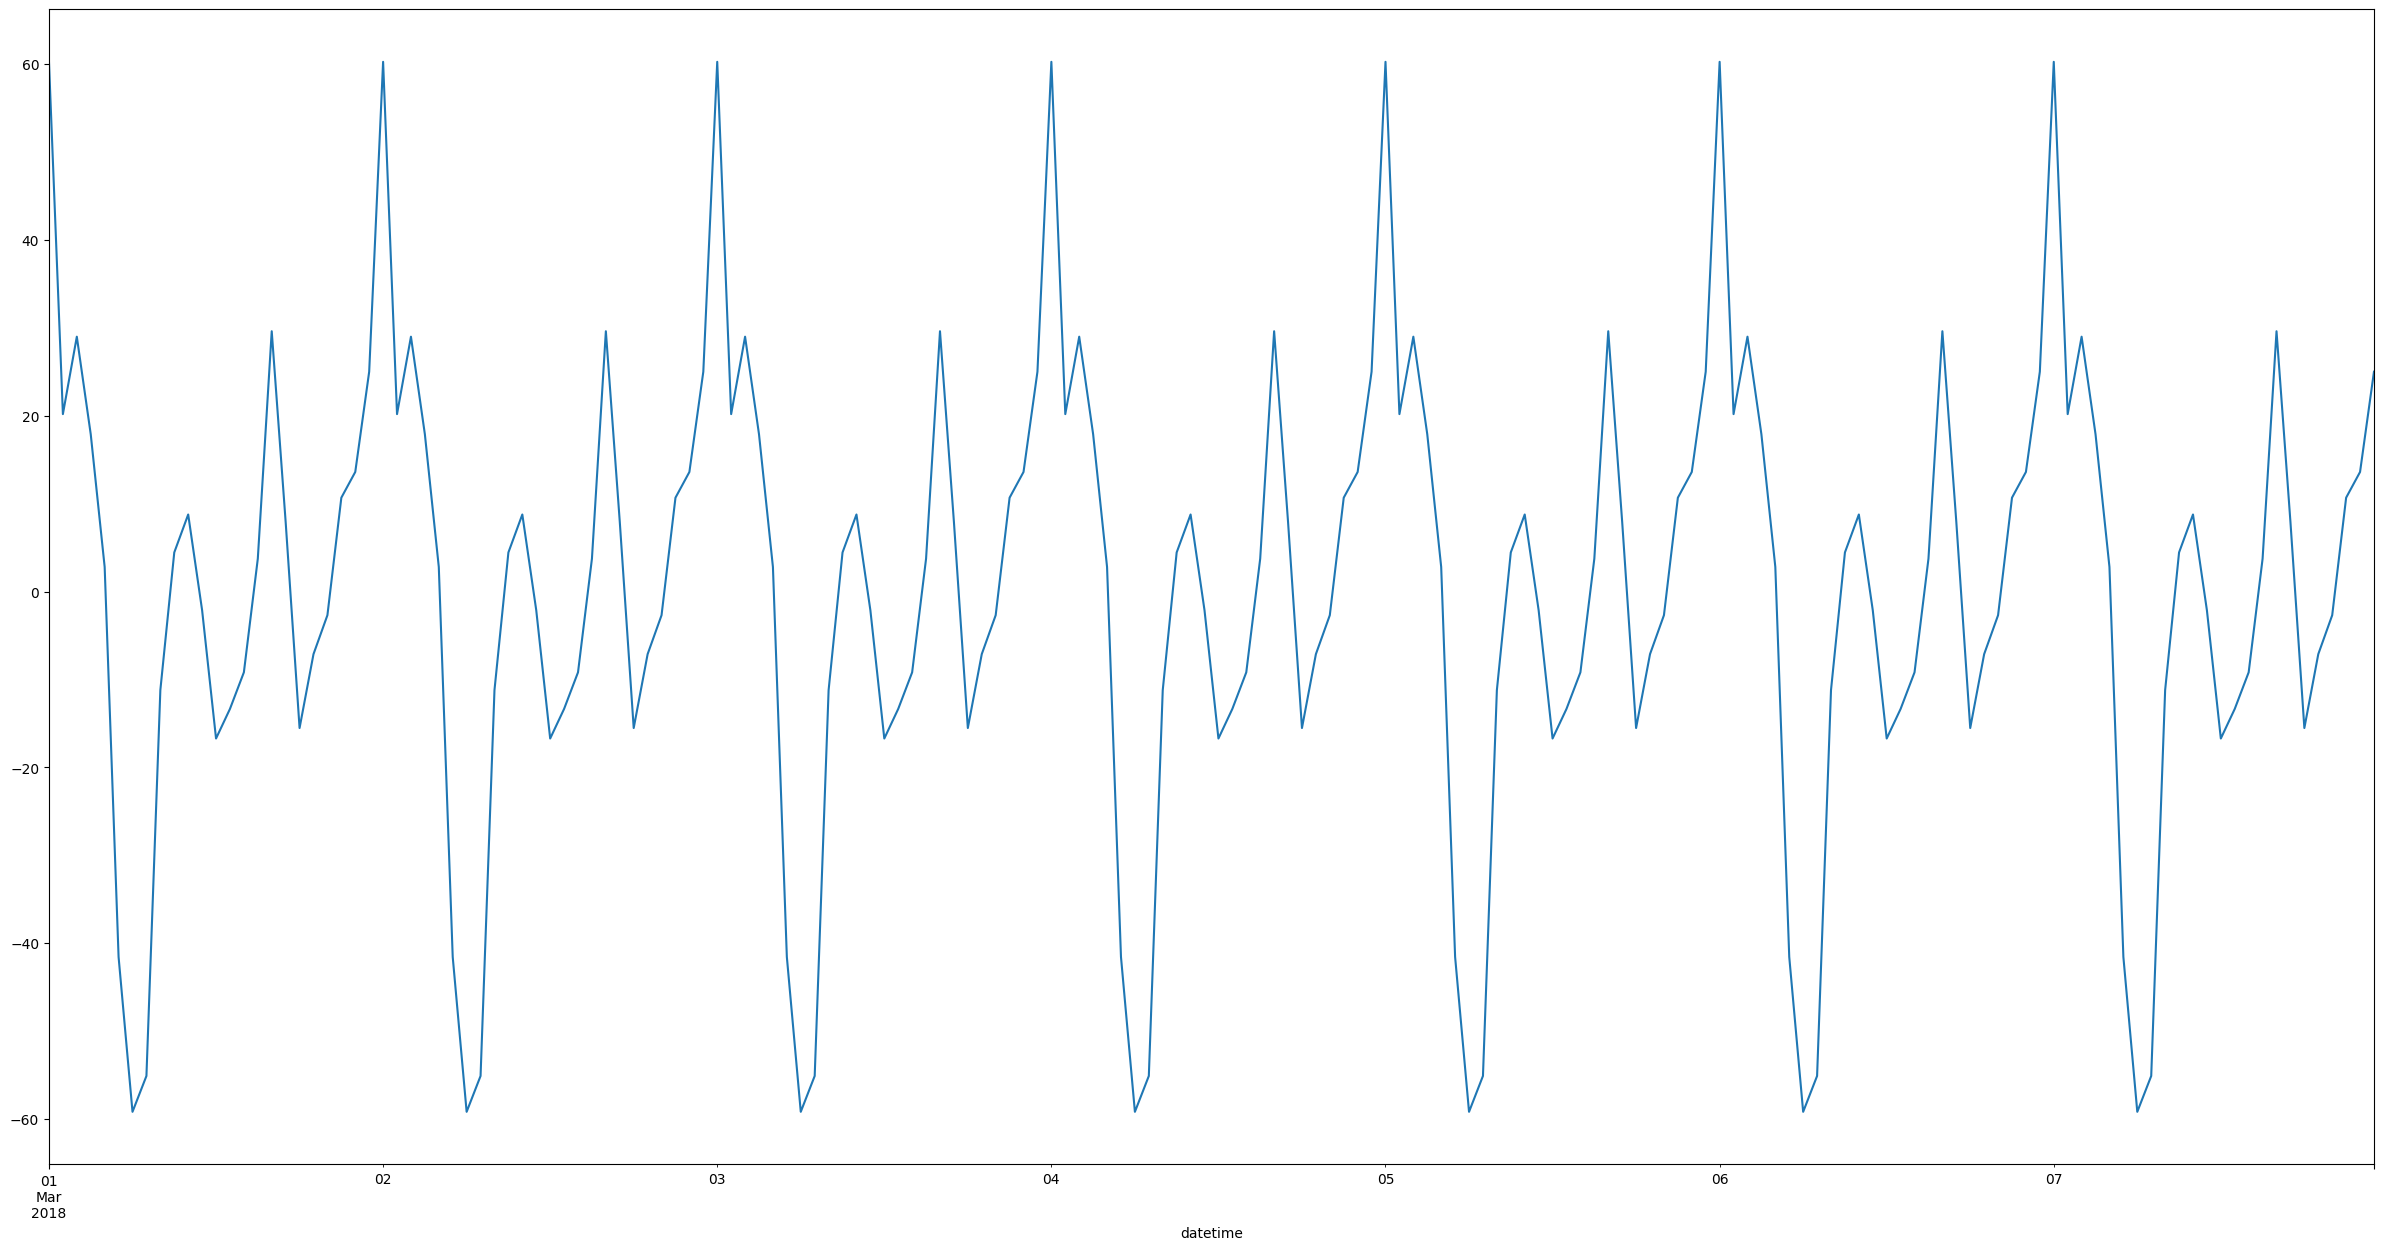

In [184]:
plt.figure(figsize=(30, 15))
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot();

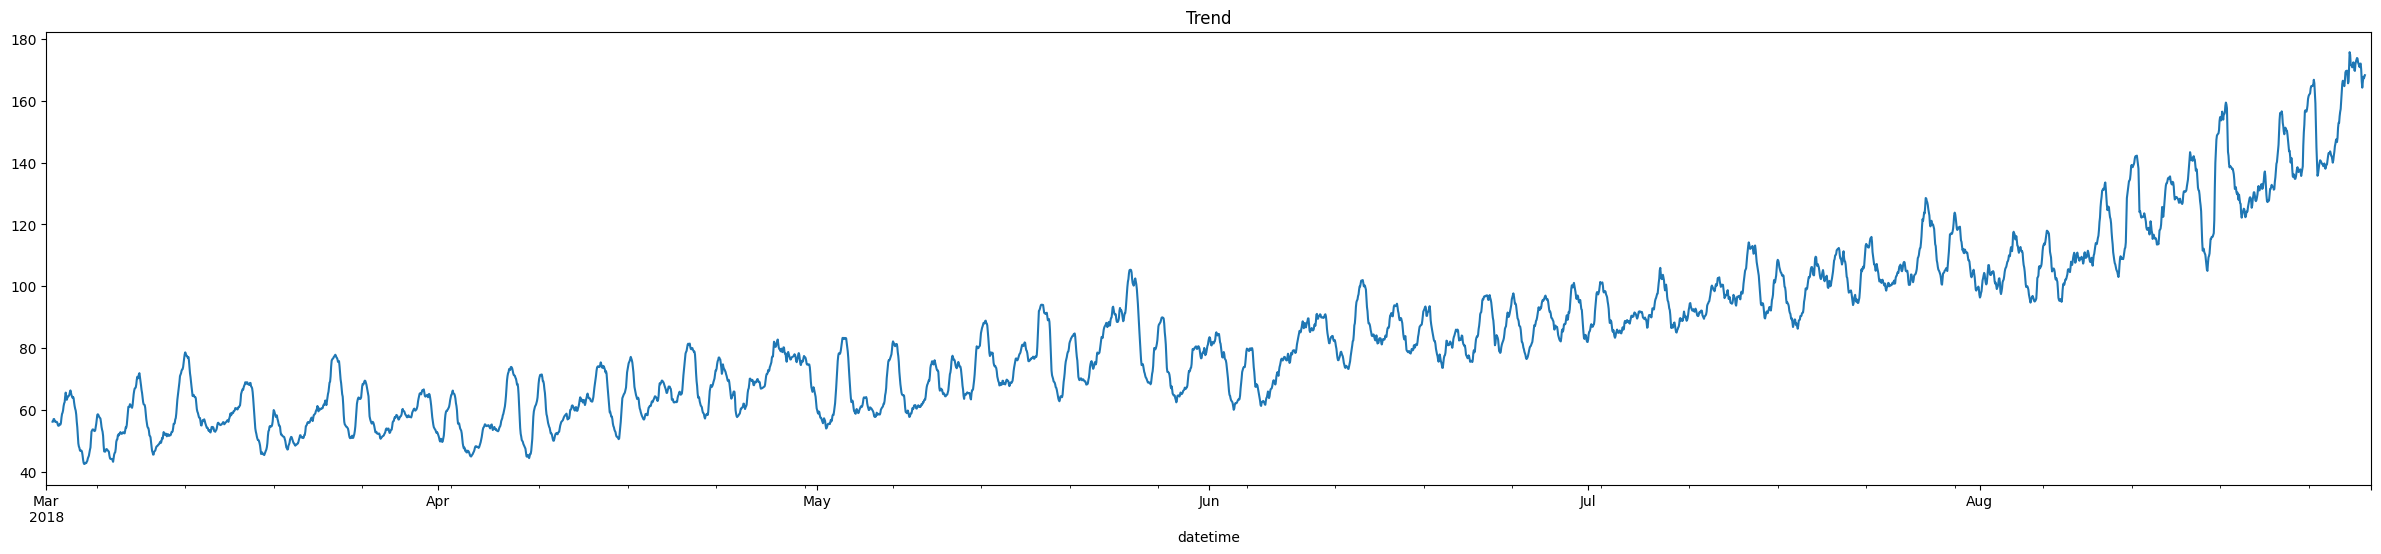

In [185]:
plt.figure(figsize=(30, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

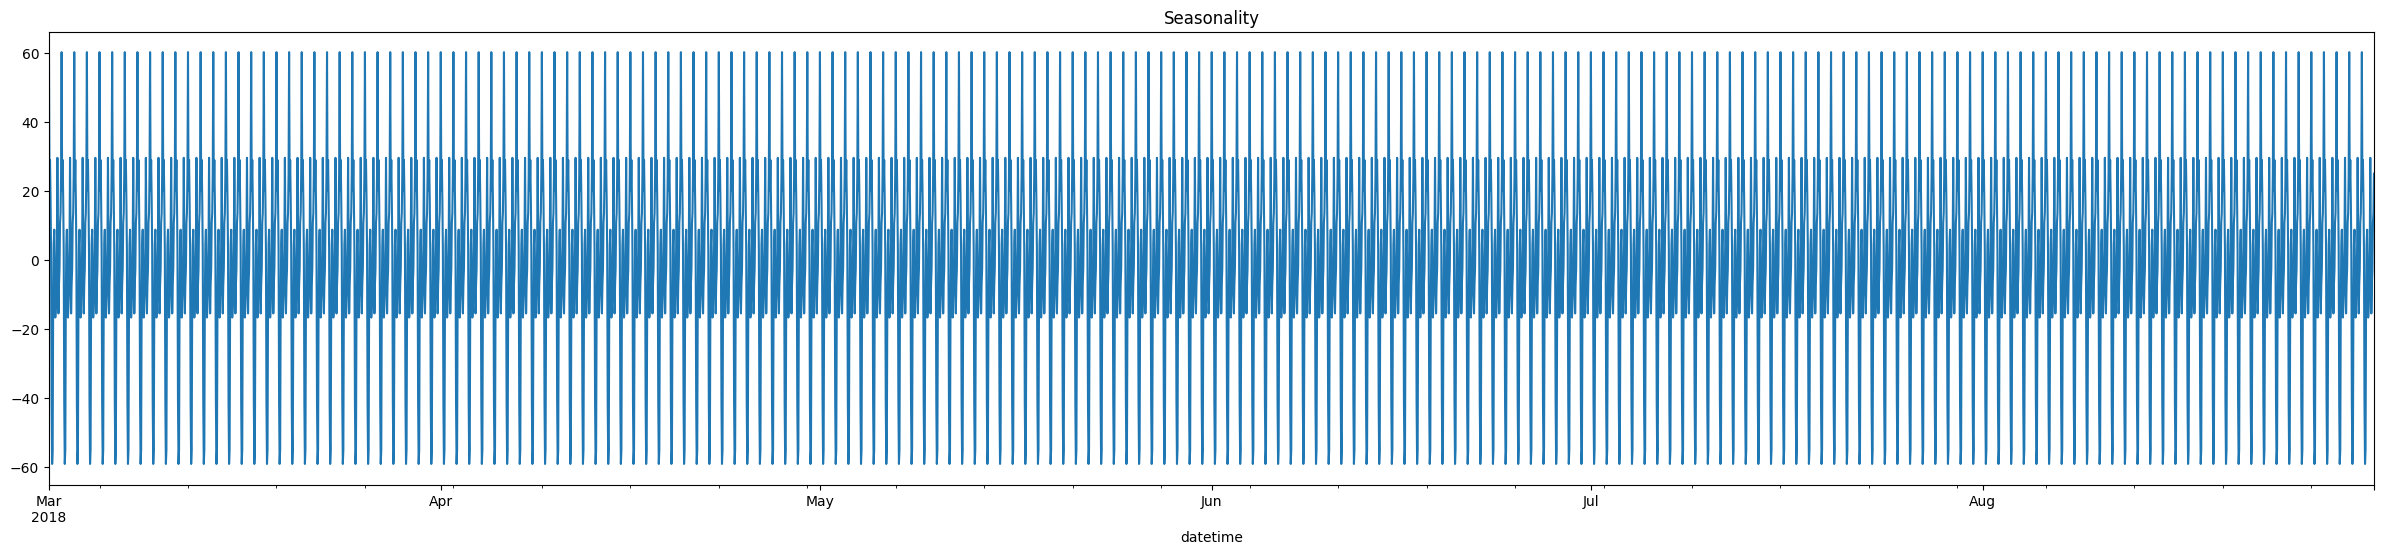

In [186]:
plt.figure(figsize=(30, 20))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality');

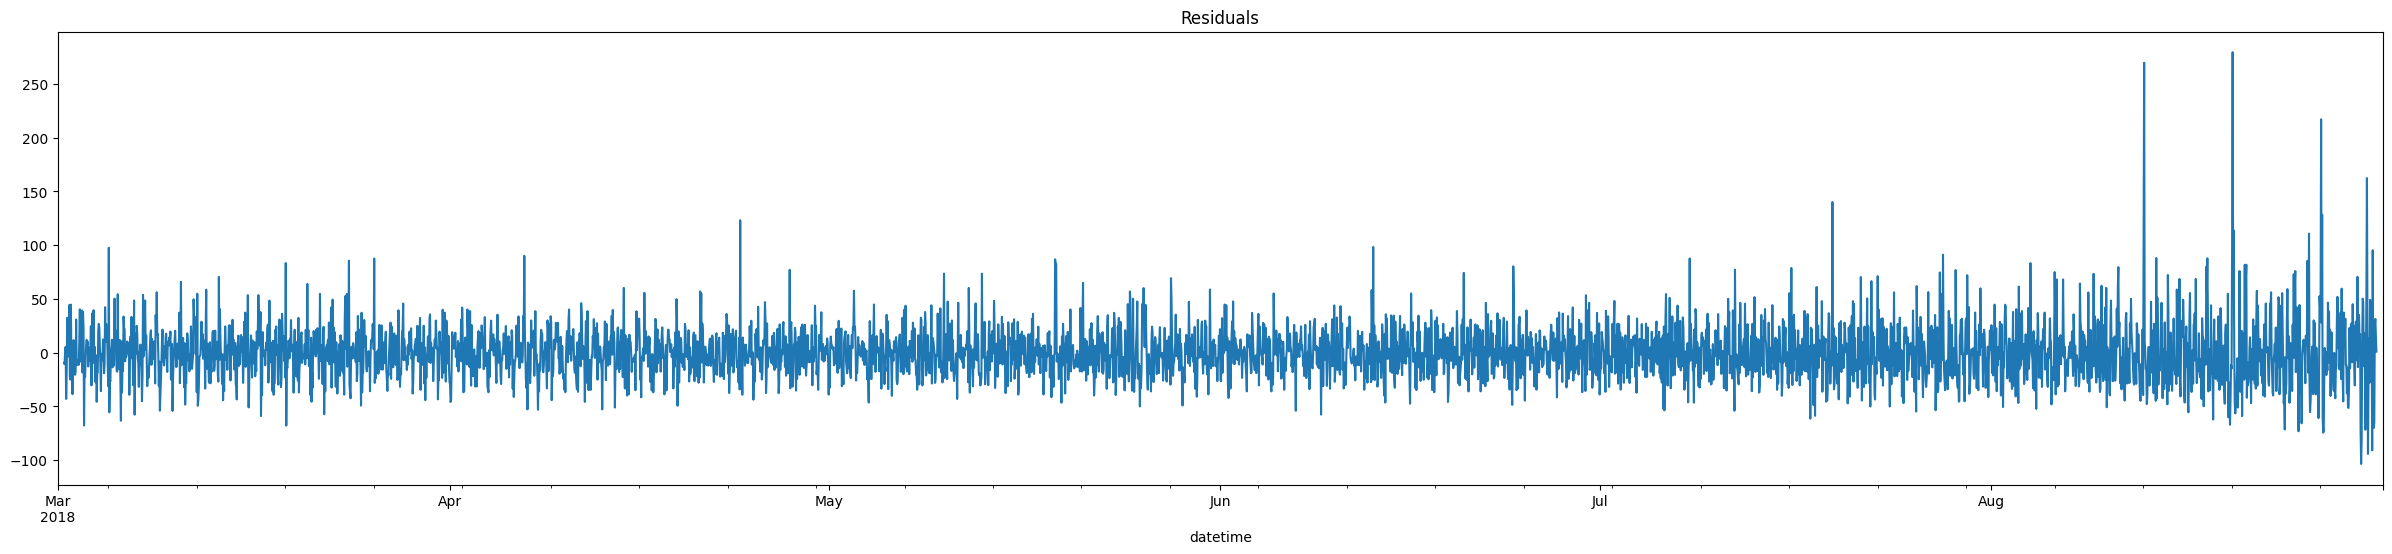

In [187]:
plt.figure(figsize=(30, 20))
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals');

## Обучение

In [ ]:
def make_features(data: pd.DataFrame) -> pd.DataFrame:
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.dayofweek >= 5
    data['is_night'] = (data['hour'] >= 0) & (data['hour'] <= 5)
    for lag in [24, 48, 72]:
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    

    for window in [3, 6, 12, 24, 168]:
        data[f'rolling_mean_{window}'] = data['num_orders'].shift().rolling(window).mean()
        data[f'rolling_std_{window}'] = data['num_orders'].shift().rolling(window).std()
    return data

In [189]:
make_features(data)
print(data.head())

                     num_orders  hour  day  dayofweek  is_weekend  is_night  \
datetime                                                                      
2018-03-01 00:00:00         124     0    1          3       False      True   
2018-03-01 01:00:00          85     1    1          3       False      True   
2018-03-01 02:00:00          71     2    1          3       False      True   
2018-03-01 03:00:00          66     3    1          3       False      True   
2018-03-01 04:00:00          43     4    1          3       False      True   

                     is_morning_rush  is_evening_rush  lag_24  lag_48  ...  \
datetime                                                               ...   
2018-03-01 00:00:00            False            False     NaN     NaN  ...   
2018-03-01 01:00:00            False            False     NaN     NaN  ...   
2018-03-01 02:00:00            False            False     NaN     NaN  ...   
2018-03-01 03:00:00            False            False   

In [190]:
def data_split(data: pd.DataFrame, drop_col: str
               ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    train, test = train_test_split(
        data,
        shuffle=False,
        test_size=TEST_SIZE)
    train = train.dropna()
    X_train = train.drop(columns=drop_col)
    y_train = train.num_orders
    X_test = test.drop(columns=drop_col)
    y_test = test.num_orders
    return X_train, X_test, y_train, y_test
    

In [191]:
X_train, X_test, y_train, y_test = data_split(data, 'num_orders')

In [192]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3806, 20) (442, 20) (3806,) (442,)


In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   num_orders        4416 non-null   int64  
 1   hour              4416 non-null   int32  
 2   day               4416 non-null   int32  
 3   dayofweek         4416 non-null   int32  
 4   is_weekend        4416 non-null   bool   
 5   is_night          4416 non-null   bool   
 6   is_morning_rush   4416 non-null   bool   
 7   is_evening_rush   4416 non-null   bool   
 8   lag_24            4392 non-null   float64
 9   lag_48            4368 non-null   float64
 10  lag_72            4344 non-null   float64
 11  rolling_mean_3    4413 non-null   float64
 12  rolling_std_3     4413 non-null   float64
 13  rolling_mean_6    4410 non-null   float64
 14  rolling_std_6     4410 non-null   float64
 15  rolling_mean_12   4404 non-null   float64
 16

In [ ]:
# plt.figure(figsize=(15, 13))
# sns.heatmap(phik_matrix(data, interval_cols=['num_orders', 
#                                              'day', 
#                                              'dayofweek',
#                                              'lag_1',
#                                              'lag_2',
#                                              'lag_3',
#                                              'lag_4',
#                                              'lag_5',
#                                              'lag_6',
#                                              'lag_7',
#                                              'rolling_mean']), annot=True, cmap='coolwarm')
# plt.show()

KeyboardInterrupt: 

<Figure size 1500x1300 with 0 Axes>

In [195]:
def objective_lgb(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'objective': 'regression', 
        'metric': 'rmse',
        'verbosity': -1,
        'random_state': RANDOM_STATE
    }
    
    kf = KFold(n_splits=5, shuffle=False)
    cv_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dval = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dval],
            callbacks=[
                lgb.early_stopping(stopping_rounds=10, verbose=False),
                lgb.log_evaluation(False)
            ]
        )
        
        preds = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, preds))
        cv_scores.append(score)
    
    return np.mean(cv_scores)

In [196]:
study_lgb = optuna.create_study(direction='minimize')  
study_lgb.optimize(objective_lgb, n_trials=30)

[I 2025-04-23 18:41:12,155] A new study created in memory with name: no-name-9ec251a0-64a9-49a6-880b-40470c5e990e
[I 2025-04-23 18:41:12,500] Trial 0 finished with value: 23.899578028824948 and parameters: {'num_leaves': 119, 'learning_rate': 0.029615248976285643, 'max_depth': 10, 'min_child_samples': 188, 'subsample': 0.5265938948877987, 'colsample_bytree': 0.910557510134331, 'reg_alpha': 2.0624370714793347e-05, 'reg_lambda': 0.1998064775804609}. Best is trial 0 with value: 23.899578028824948.
[I 2025-04-23 18:41:12,764] Trial 1 finished with value: 39.63717899827611 and parameters: {'num_leaves': 42, 'learning_rate': 0.00019869400582474476, 'max_depth': 7, 'min_child_samples': 102, 'subsample': 0.5130185026305234, 'colsample_bytree': 0.5844124825973838, 'reg_alpha': 0.0011794942093565951, 'reg_lambda': 0.4257885875073357}. Best is trial 0 with value: 23.899578028824948.
[I 2025-04-23 18:41:13,027] Trial 2 finished with value: 24.74325096641615 and parameters: {'num_leaves': 192, 'lea

In [197]:
print("\nBest trial:")
trial_lgb = study_lgb.best_trial

print(f"  RMSE: {trial_lgb.value:.4f}")
print("  Params: ")
for key, value in trial_lgb.params.items():
    print(f"    {key}: {value}")


Best trial:
  RMSE: 22.5954
  Params: 
    num_leaves: 21
    learning_rate: 0.08316263034653795
    max_depth: 8
    min_child_samples: 47
    subsample: 0.6408688056960566
    colsample_bytree: 0.7603305311620252
    reg_alpha: 0.0032992056291379856
    reg_lambda: 0.002452347072282036


In [198]:
def objective_lr(trial):
    params = {
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'positive': trial.suggest_categorical('positive', [True, False]),
        'n_jobs': -1  
    }
    
    kf = KFold(n_splits=5, shuffle=False)
    cv_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LinearRegression(**params)
        model.fit(X_tr, y_tr)
        
        preds = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, preds))
        cv_scores.append(score)
    
    return np.mean(cv_scores)


In [199]:
study_lr = optuna.create_study(direction='minimize')  
study_lr.optimize(objective_lr, n_trials=10)

[I 2025-04-23 18:41:18,724] A new study created in memory with name: no-name-62f1b5df-a123-4a87-b382-491a4e8f814f
[I 2025-04-23 18:41:18,747] Trial 0 finished with value: 23.851111744632657 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 0 with value: 23.851111744632657.
[I 2025-04-23 18:41:18,770] Trial 1 finished with value: 23.851111744632657 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 0 with value: 23.851111744632657.
[I 2025-04-23 18:41:18,791] Trial 2 finished with value: 23.878170599292076 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 23.851111744632657.
[I 2025-04-23 18:41:18,808] Trial 3 finished with value: 23.540163139332652 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 3 with value: 23.540163139332652.
[I 2025-04-23 18:41:18,830] Trial 4 finished with value: 23.851111744632657 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 3 

In [200]:
print("\nBest trial:")
trial_lr = study_lr.best_trial

print(f"  RMSE: {trial_lr.value:.4f}")
print("  Params: ")
for key, value in trial_lr.params.items():
    print(f"    {key}: {value}")


Best trial:
  RMSE: 23.5398
  Params: 
    fit_intercept: True
    positive: False


## Тестирование

In [203]:
best_params = study_lgb.best_trial.params
dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(X_test, label=y_test, reference=dtrain)

final_model = lgb.train(
    best_params,
    dtrain,
    valid_sets=[dtest], 
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(50) 
    ]
)

y_test_pred = final_model.predict(X_test)


Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1663.39
[100]	valid_0's l2: 1524.52
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 1524.52


In [204]:
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"\nTest RMSE: {test_rmse:.4f}")


Test RMSE: 39.0451


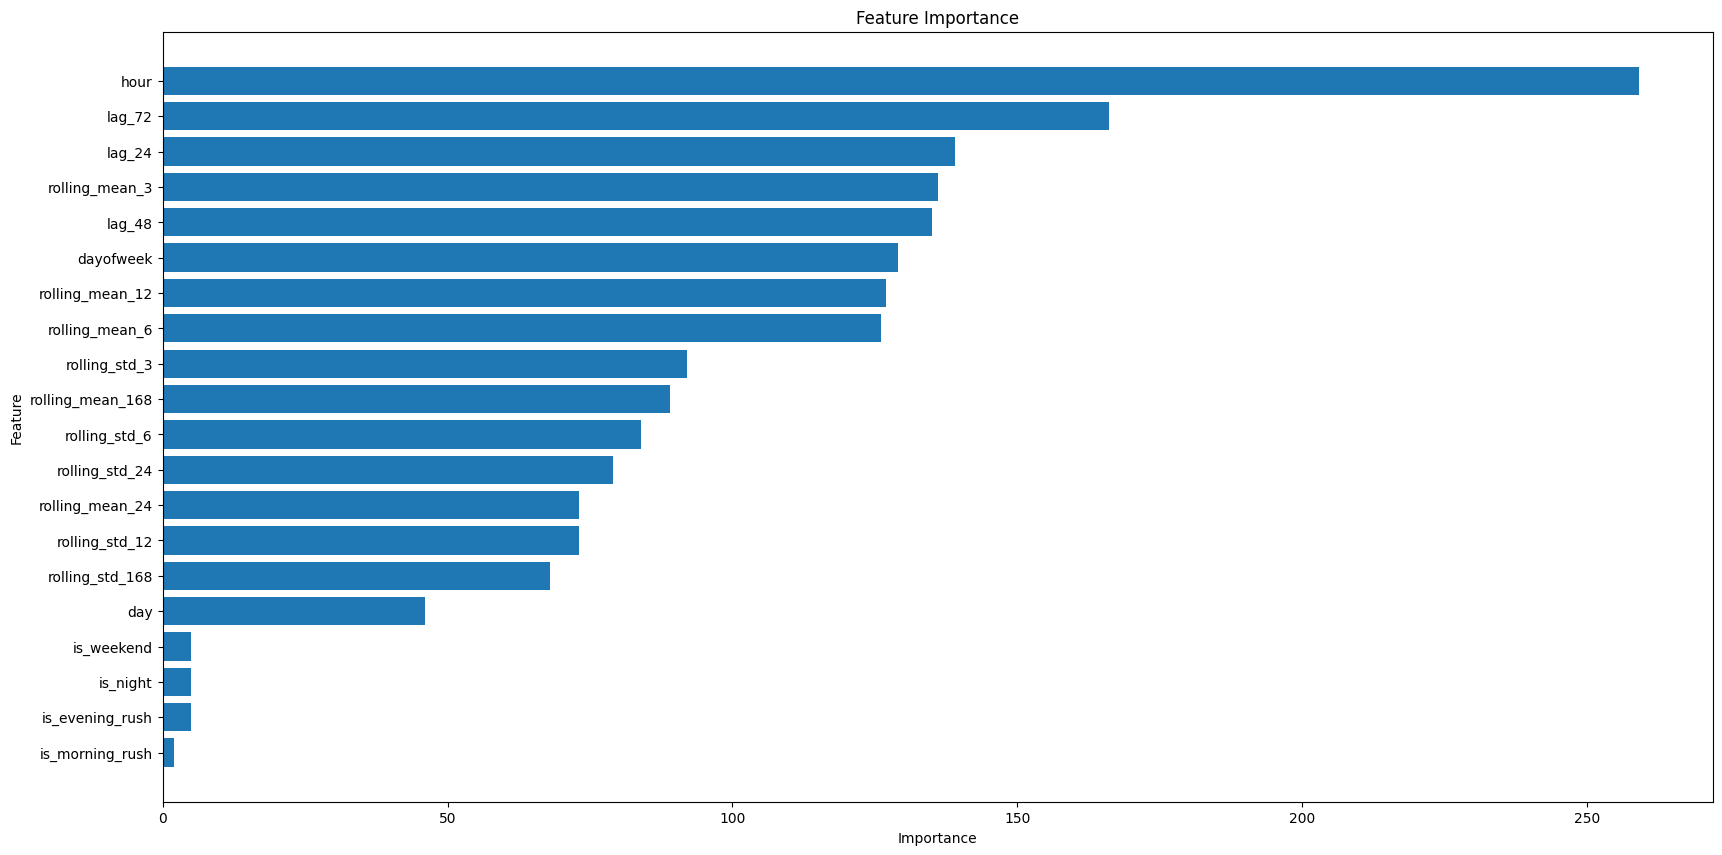

In [207]:
feature_importance_df = pd.DataFrame({
    'feature': final_model.feature_name(),
    'importance': final_model.feature_importance()
})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(20, 10))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48